# How should Skyfield handle Earth deflection?

The NOVAS library attempts to account for how light is deflected by the Earth itself for a topocentric observation. It happens in `place()`:

1. The assignment `loc = 1` is made for both topocentric place and local place.
2. But it has one chance to wind up zero anyway: the call `limb_angle()` is made to determine the target’s nadir angle as a fraction of the Earth’s angular radius (which is π/2 for an observer on the surface, and shrinks with the observer’s altitude above the surface). If the result is `< 0.8`, meaning that the object is well below the horizon, then `loc` is reset with `loc = 0`.
3. Finally, `loc` becomes the second argument to `grav_def()`, named `loc_code`, that flags whether Earth deflection should be included in its result.

## Why the value 0.8?

Is deflection not considered when the limb angle is `< 0.8` because the effect is so small in that case that it is not worth considering? That would be surprising, as I would expect deflection to increase as an object moves behind the object deflecting it. Maybe the deflection is not considered because of realism: you cannot see the object anyway if it has moved behind the Earth? But in that case, wouldn’t the sudden cut-off cause an unpleasant discontinuity?



In [12]:
%pylab inline
import seaborn as sbs
from novas import compat as novas
from novas.compat import eph_manager

jd_start, jd_end, number = eph_manager.ephem_open()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [13]:
RMASS = [328900.561400, 6023600.0, 408523.71,
      332946.050895, 3098708.0, 1047.3486, 3497.898, 22902.98,
      19412.24, 135200000.0, 1.0, 27068700.387534]

print 'It takes', RMASS[3], 'Earth masses to equal the mass of the Sun'

It takes 332946.050895 Earth masses to equal the mass of the Sun


In [14]:
#dir(novas)

In [15]:
ERAD = 6378136.6             # meters (from NOVAS source code)
AU = 1.4959787069098932e+11  # meters (from NOVAS source code)
ERAD_AU = ERAD / AU
print 'The earth is {:.3} au in radius'.format(ERAD_AU)

The earth is 4.26e-05 au in radius


In [16]:
def deflection_at(degrees):
    theta = pi / 180.0 * degrees
    pos1 = [sin(theta), 0, cos(theta)]  # object at 1 AU on +z axis
    pos_obs = [0, 0, 0]                 # observer at origin
    pos_body = [0, 0, ERAD_AU]          # Earth center on +z axis
    pos2 = novas.grav_vec(pos1, pos_obs, pos_body, RMASS[3])
    theta2 = arctan2(pos2[0], pos2[2])
    return 180.0 / pi * theta2

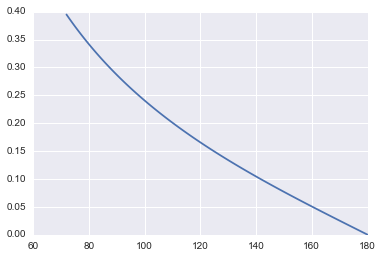

In [17]:
limit = 90.0 * 0.8
degrees = linspace(limit, 180.0, 101)
degrees2 = [deflection_at(i) for i in degrees]
mas = 60 * 60 * 1000 * (degrees2 - degrees)
plot(degrees, mas)

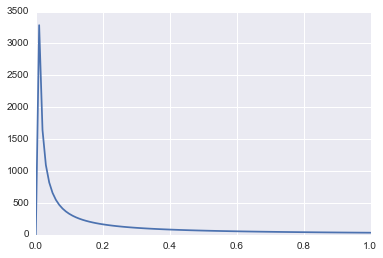

In [18]:
degrees = linspace(0.0, 1.0, 101)
degrees2 = [deflection_at(i) for i in degrees]
mas = 60 * 60 * 1000 * (degrees2 - degrees)
plot(degrees, mas)

# So - creates a step function?

We need to find a moment when another body crests 0.8 behind the Earth. This should happen each evening when the object sets!

In [96]:
mars = novas.make_object(0, 4, 'Mars', None)

latitude = 35.2029
longitude = -111.6646
height = 2210  # meters
temperature = 25.0
pressure = 0.0
lowell = novas.make_on_surface(latitude, longitude, height, temperature, pressure)

def mars_radec(hour):
    jd_tt = novas.julian_date(2016, 7, 2, hour)
    ra, dec, dis = novas.topo_planet(jd_tt, 0.0, mars, lowell)
    return ra, dec

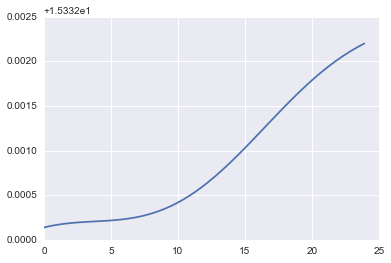

In [131]:
hour = linspace(0.0, 23.9, 101)
ra = [mars_radec(h)[0] for h in hour]
plot(hour, ra)

So, when in that day did Mars cross the threshold of being `0.8 * pi` away from the center of the Earth from the point of view of the Lowell Observatory?

In [132]:
earth = novas.make_object(0, 3, 'Earth', None)
lowell2 = novas.make_observer_on_surface(
    latitude, longitude, height, temperature, pressure)

def to_vector(ra, dec, dis):
    ra = pi / 12.0 * ra
    dec = pi / 180.0 * dec
    x = dis * cos(dec) * cos(ra)
    y = dis * cos(dec) * sin(ra)
    z = dis * sin(dec)
    return x, y, z

def nadir_angle(hour):
    jd_tt = novas.julian_date(2016, 7, 2, hour)
    lowell_pos, lowell_vel = novas.geo_posvel(jd_tt, 0.0, lowell2)
    ra, dec, dis = novas.astro_planet(jd_tt, mars)
    mx, my, mz = to_vector(ra, dec, dis)
    limb_angle, nadir_angle = novas.limb_angle((mx, my, mz), lowell_pos)
    return nadir_angle

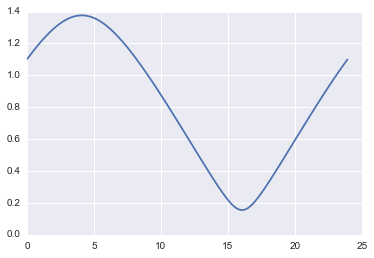

In [133]:
nadir = array([nadir_angle(h) for h in hour])
plot(hour, nadir)

In [142]:
indexes, = nonzero(numpy.diff(numpy.sign(nadir - 0.8)))
crossings = hour[indexes]
print indexes
print crossings

[44 89]
[ 10.516  21.271]


It looks like the curve crosses 0.8 somewhere between hour 10 and hour 11. If we search for a discontinuity, will we find it at the same place?

In [130]:
# Takes several seconds to run:

hour_highres = linspace(0.0, 23.9, 100000)
values = [mars_radec(h)[0] for h in hour_highres]

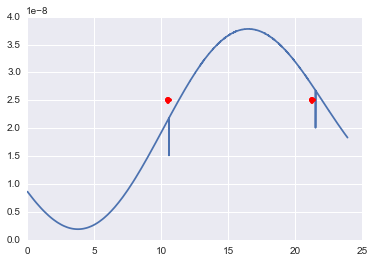

In [151]:
plot(hour_highres[:-1], np.diff(values))
plot(crossings, [2.5e-8] * len(crossings), 'ro')

Remaining mystery: why is the discontinuity not negative when crossing one limb and positive when crossing the other?